# Extraction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import util

# Data extraction of weather data from open-meteo free API, no need to sign up
openMeteoURL = "https://archive-api.open-meteo.com/v1/era5"

# Rome geographical coordinates
latitude = 41.9027
longitude = 12.4963
# We are going to exctract 10 years of weather data between the following time interal:
start_date = "2012-01-01"
end_date = "2022-12-31"

# The function below converts the JSON data into a Pandas Dataframe
# For this project we are going to analyze the temperature and precipitation data
dfWeather = util.get_json_data(openMeteoURL, latitude, longitude, start_date, end_date)

dfWeather.head(3)

,time,temperature,precipitation
0,2012-01-01T00:00,1.3,0.0
1,2012-01-01T01:00,1.1,0.0
2,2012-01-01T02:00,0.9,0.0


# Transformation

# 1. Finding the max temperature reached for each summer

In [2]:
# In order to convert the time column from string to datetime we can use a UDF, then drop the old string column
dfWeather["time_converted"] = dfWeather["time"].apply(util.convert_to_datetime)

In [3]:
# Drop the old column time and rename the new one
dfWeather = dfWeather.drop("time", axis=1)
dfWeather.rename(columns={'time_converted': 'time'}, inplace=True)
dfWeather.head(3)

,temperature,precipitation,time
0,1.3,0.0,2012-01-01 00:00:00
1,1.1,0.0,2012-01-01 01:00:00
2,0.9,0.0,2012-01-01 02:00:00


In [4]:
# As first analysis, we want to find the max temperature registered for each summer during the years,
# For semplicity we define the following time intervals for each season:
# Spring (march, april, may), Summer (june, july, august), 
# Autumn (september, october, november), Winter (december, january, february)

dfSummer = dfWeather \
            .where((dfWeather["time"].dt.month >= 6) & (dfWeather["time"].dt.month <= 8)) \
            .groupby(dfWeather["time"].dt.year) \
            .agg( {"temperature":"max"} ) \
            .rename_axis(["year"]) \
            .sort_values(by = "year", ascending = False)

dfSummer.head(3)

,temperature
year,
2022,36.7
2021,36.6
2020,36.2


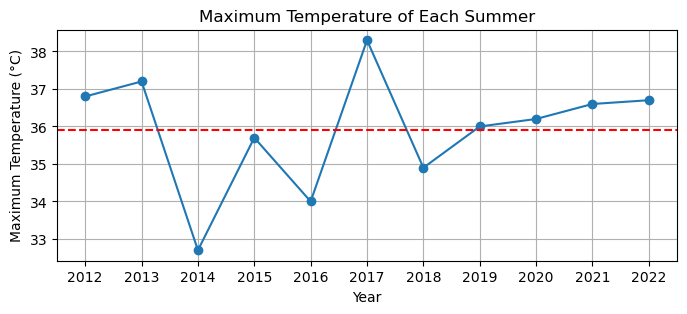

In [5]:
# Initialize and set the chart size
plt.figure(figsize=(8, 3))

# Create the line chart using the Dataframe index (year) and values (max temperature of each year)
plt.plot(dfSummer.index, dfSummer.values, marker='o')

# Calculate the median value (we can use it as a threshold to better visualize which year is higher than the mean)
median = dfSummer["temperature"].mean()

# Add the median line
plt.axhline(y=median, color='red', linestyle='--', label='Median')

# Cosmetic updates
plt.xlabel('Year')
plt.ylabel('Maximum Temperature (°C)')
plt.title('Maximum Temperature of Each Summer')
plt.grid(True)
plt.xticks(dfSummer.index.astype(int))

# Print the chart
plt.show()

# 2. Finding the average precipitation for each season of every year

In [6]:
# As second analysis, we want to discover and visualize the distribution of the average precipitation for each season of every year
# In order to partition the months in season, we first group by year-months, then merge the target months for each season
dfPrec = dfWeather \
            .where(dfWeather["precipitation"] > 0) \
            .groupby([dfWeather["time"].dt.year, dfWeather["time"].dt.month]) \
            .agg( {"precipitation":"mean"} ) \
            .rename_axis(["year", "month"]) \
            .reset_index()

dfPrec.head(5)

,year,month,precipitation
0,2012,1,0.400000
1,2012,2,0.791667
2,2012,3,0.527273
3,2012,4,0.598020
4,2012,5,0.784946


In [7]:
# We have to separate the season for each year:
# Spring (march, april, may), Summer (june, july, august), Autumn (september, october, november), Winter (december, january, february)
dfSpring = util.calculate_mean_prec_season(dfPrec, "spring")
dfSummer = util.calculate_mean_prec_season(dfPrec, "summer")
dfAutumn = util.calculate_mean_prec_season(dfPrec, "autumn")
dfWinter = util.calculate_mean_prec_season(dfPrec, "winter")

In [8]:
# Merge of the all Dataframes containing data of each season
dfFinal = pd.concat([dfSpring, dfSummer, dfAutumn, dfWinter], axis=0)
dfFinal = dfFinal.sort_values(by = "year")

dfFinal.head(5)

,year,precipitation,season
0,2012,0.636746,spring
0,2012,1.094096,autumn
0,2012,0.600815,summer
0,2012,0.629489,winter
1,2013,1.021033,autumn


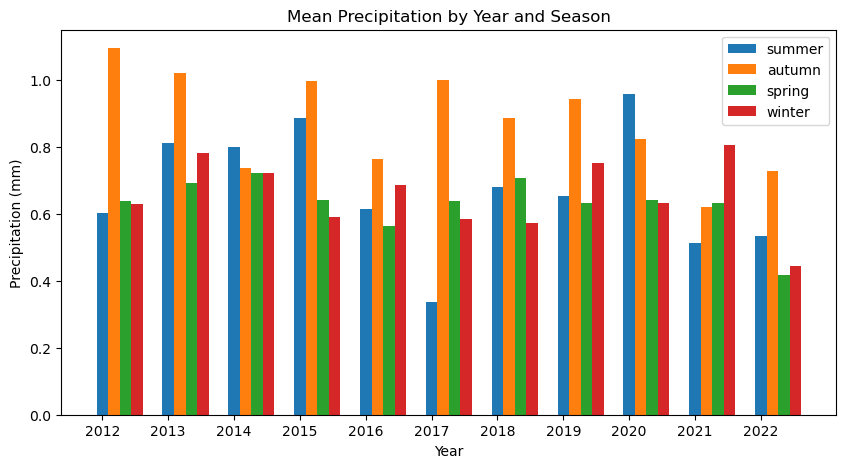

In [9]:
# Define of years and seasons
years = dfFinal["year"].unique()
seasons = ["summer", "autumn", "spring", "winter"]

# Get the number of seasons and the width for each bar
num_seasons = len(seasons)
bar_width = 0.7 / num_seasons

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,5))

# In order to better visualize the distribution we are going to use a bar chart
# Plot the bars for each season in each year
for i, season in enumerate(seasons):
    x = [j + i * bar_width for j in range(len(years))]
    data = dfFinal.where(dfFinal["season"] == season).dropna()
    ax.bar(x, data["precipitation"], width=bar_width, label=season, align="center")

# Set axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Mean Precipitation by Year and Season')

# Set x-axis tick labels as years
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)

# Add a legend
ax.legend()

# Print the bar chart
plt.show()

# Loading

In [10]:
# Now that we performed the Extraction and Transformation actions, we want to Load the data in a Postgres DB as last step of our ETL pipeline
# Let's suppose we want to load the raw data initially obtained (dfWeather) into a table called Weather_Data,
# and the transformed data (dfFinal)
from database import DatabaseConnector

In [11]:
# Defining database connection parameters
host = 'localhost'
port = 5432  
database = 'weather'
user = 'postgres'
password = 'postgres'

# Creating the object DatabaseConnector
db = DatabaseConnector(host, port, database, user, password)
db.connect()

Connection successful!


In [12]:
# Given the city as input, get the id from City table
city = 'Rome'
idCity = db.select_id_from_city(city)
print(f"Selected city ID: {idCity}")

Selected city ID: 1


In [13]:
# In order to insert the dataframe, we first order the columns in the same position as the db table
dfWeather.insert(0, "city_id", idCity)
col = dfWeather.pop("time")
dfWeather.insert(1, "time", col)

dfWeather.head(3)

,city_id,time,temperature,precipitation
0,1,2012-01-01 00:00:00,1.3,0.0
1,1,2012-01-01 01:00:00,1.1,0.0
2,1,2012-01-01 02:00:00,0.9,0.0


In [14]:
# Insert raw data in Weather_Data table
db.insert_data_from_dataframe("Weather_Data", dfWeather)

Data successfully written into Database.


In [15]:
# In order to insert the dataframe, we first order the columns in the same position as the db table
dfFinal.insert(0, "city_id", idCity)
dfFinal.rename(columns={'precipitation':'mean_precipitation', 'season':'season_name'}, inplace=True)

dfFinal.head(3)

,city_id,year,mean_precipitation,season_name
0,1,2012,0.636746,spring
0,1,2012,1.094096,autumn
0,1,2012,0.600815,summer


In [16]:
# Insert data in Season table
db.insert_data_from_dataframe("Season", dfFinal)

Data successfully written into Database.


In [17]:
db.disconnect()

Connection closed.
